In [1]:
!pip install imbalanced-learn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install xgboost


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install lightgbm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Class distribution after SMOTE: {1: 500, 0: 500}
Selected features: ['DiabetesPedigreeFunction', 'Age', 'Glucose_BMI_Interaction', 'Age_Glucose_Ratio', 'BMI_Age_Interaction', 'Glucose_squared']

Training Random Forest with tuned hyperparameters...
Fitting 4 folds for each of 648 candidates, totalling 2592 fits
Best parameters: {'bootstrap': True, 'class_weight': {0: 1, 1: 2}, 'max_depth': 20, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 400}

Optimal classification threshold: 0.4444

Optimized Model Evaluation:
Accuracy: 0.8030 (80.30%)
ROC AUC: 0.8799
Precision: 0.7581
Recall: 0.8900
F1 Score: 0.8188


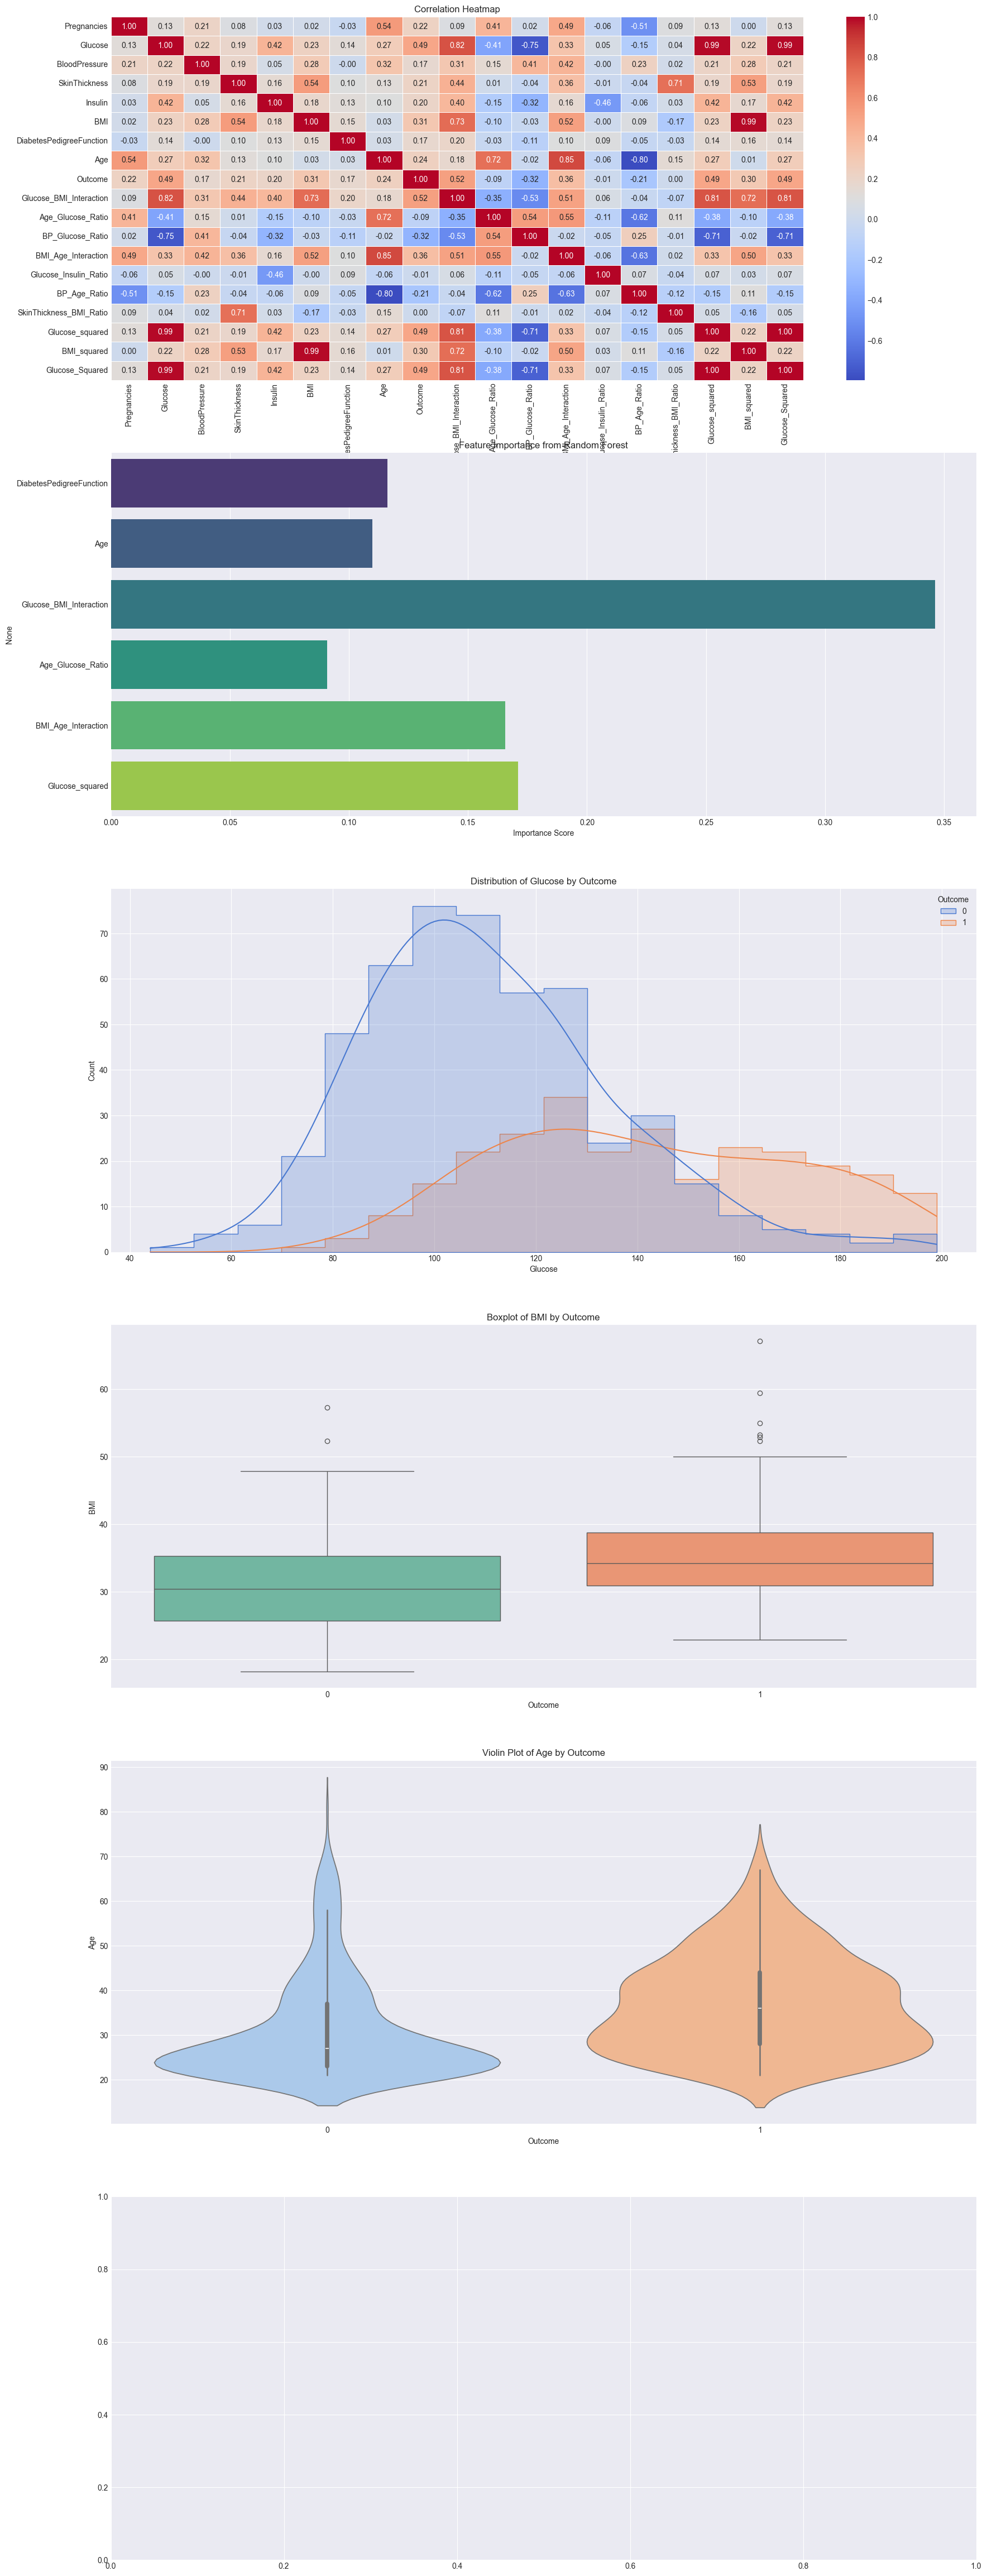

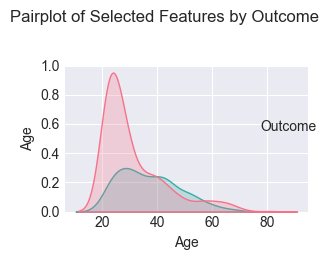

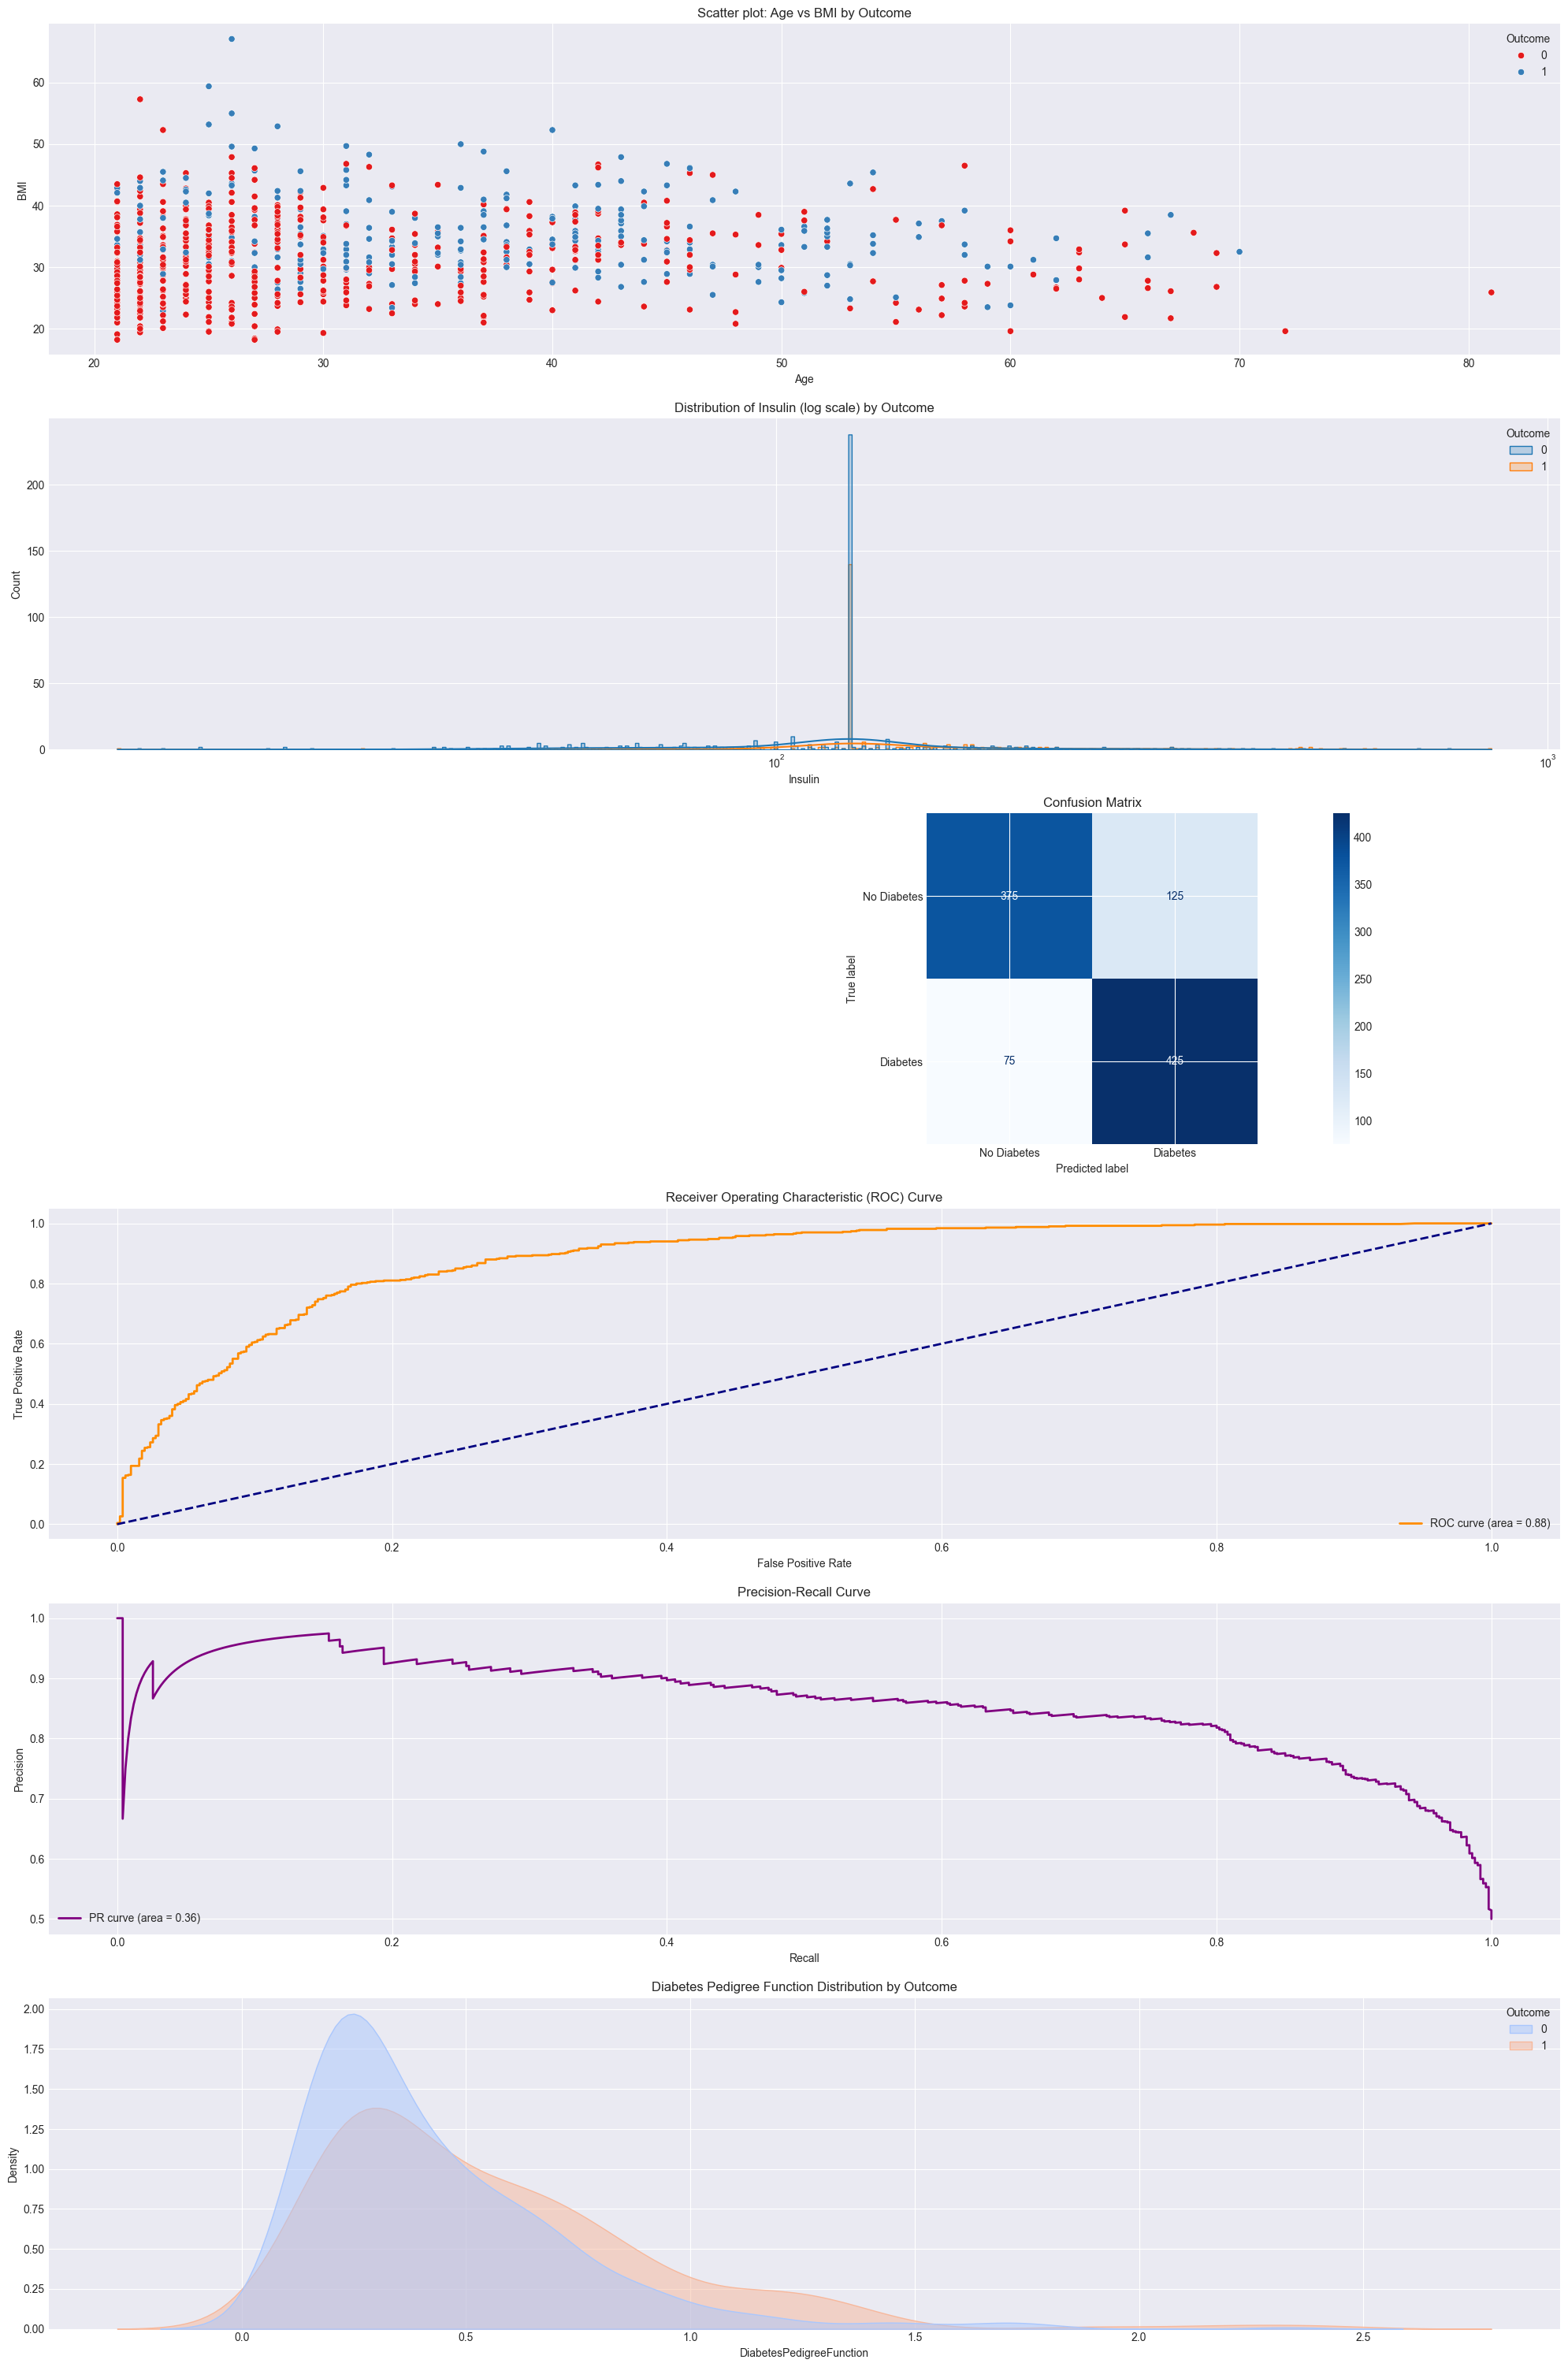


Enter patient details for diabetes prediction:


KeyboardInterrupt: Interrupted by user

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_curve, roc_auc_score,
                           precision_recall_curve, classification_report,
                           ConfusionMatrixDisplay, PrecisionRecallDisplay,
                           precision_score, recall_score, f1_score) # Import necessary metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

def load_data(path='diabetes.csv'):
    """Load the diabetes dataset"""
    data = pd.read_csv(path)
    return data

def preprocess_data(data):
    """Handle missing values and data cleaning"""
    # Replace zeros with median for relevant features
    zero_not_allowed = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    for column in zero_not_allowed:
        median = data[column].replace(0, np.nan).median()
        data[column] = data[column].replace(0, median)

    # Create new features
    data['Glucose_BMI_Interaction'] = data['Glucose'] * data['BMI']
    data['Age_Glucose_Ratio'] = data['Age'] / (data['Glucose'] + 1e-6)
    data['BP_Glucose_Ratio'] = data['BloodPressure'] / (data['Glucose'] + 1e-6)
    data['BMI_Age_Interaction'] = data['BMI'] * data['Age']
    data['Glucose_Insulin_Ratio'] = data['Glucose'] / (data['Insulin'] + 1e-6)
    data['BP_Age_Ratio'] = data['BloodPressure'] / (data['Age'] + 1e-6)
    data['SkinThickness_BMI_Ratio'] = data['SkinThickness'] / (data['BMI'] + 1e-6)
    data['Glucose_squared'] = data['Glucose']**2
    data['BMI_squared'] = data['BMI']**2
    data['Glucose_Squared'] = data['Glucose']**2

    return data

def create_preprocessor():
    """Create preprocessing pipeline"""
    numeric_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                      'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age',
                      'Glucose_BMI_Interaction', 'Age_Glucose_Ratio',
                      'BP_Glucose_Ratio', 'BMI_Age_Interaction',
                      'Glucose_Insulin_Ratio', 'BP_Age_Ratio',
                      'SkinThickness_BMI_Ratio', 'Glucose_squared', 'BMI_squared']

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())  # RobustScaler handles outliers better
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ])

    return preprocessor

def handle_class_imbalance(X, y):
    """Apply SMOTE to handle class imbalance"""
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print(f"Class distribution after SMOTE: {pd.Series(y_res).value_counts().to_dict()}")
    return X_res, y_res

def select_features(X, y):
   
    selector = SelectFromModel(
        GradientBoostingClassifier(random_state=42),
        threshold='1.25*median'  
    )
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()]
    print(f"Selected features: {list(selected_features)}")
    return selector.transform(X), selected_features

def tune_random_forest(X, y):
    """Hyperparameter tuning for Random Forest"""
    param_grid = {
        'n_estimators': [200, 300, 400],  
        'max_depth': [15, 20, 25],       
        'min_samples_split': [3, 5, 7],   
        'min_samples_leaf': [1, 2],       
        'max_features': ['sqrt', 0.5, 0.7],  
        'class_weight': ['balanced', {0:1, 1:2}],  
        'bootstrap': [True, False]        
    }

    rf = RandomForestClassifier(random_state=42)
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=kfold,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X, y)
    print(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

def create_ensemble_model():
    """Create an ensemble of models"""
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=42
    )

    xgb = XGBClassifier(
        learning_rate=0.1,
        n_estimators=200,
        max_depth=5,
        subsample=0.8,
        random_state=42
    )

    lgbm = LGBMClassifier(
        learning_rate=0.05,
        n_estimators=300,
        max_depth=7,
        random_state=42
    )

    ensemble = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgbm', lgbm)],
        voting='soft'
    )

    return ensemble



# Modified plot_all_graphs to accept selected_features
def plot_all_graphs(data, model, X, y, pred_probs, y_pred, selected_features):
    """Create 12 comprehensive visualizations"""
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.figure(figsize=(20, 120))
    plot_num = 1

    # 1. Correlation Heatmap
    plt.subplot(12, 1, plot_num)
    sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plot_num +=1

    # 2. Feature Importance
    plt.subplot(12, 1, plot_num)
    
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        
        if len(feature_importances) == len(selected_features):
            features_to_plot = selected_features
            sns.barplot(x=feature_importances, y=features_to_plot, palette="viridis")
            plt.title("Feature Importance from Random Forest")
            plt.xlabel('Importance Score')
        else:
             print("Warning: Feature importance length does not match selected features. Skipping plot.")
    else:
        print("Warning: Model does not have feature_importances_ attribute. Skipping plot.")
    plot_num +=1

    # 3. Distribution of Glucose by Outcome
    plt.subplot(12, 1, plot_num)
    sns.histplot(data, x='Glucose', hue='Outcome', kde=True, element="step", palette="muted")
    plt.title("Distribution of Glucose by Outcome")
    plot_num +=1

    # 4. Boxplot of BMI by Outcome
    plt.subplot(12,1, plot_num)
    sns.boxplot(x='Outcome', y='BMI', data=data, palette="Set2")
    plt.title("Boxplot of BMI by Outcome")
    plot_num +=1

    # 5. Violin plot for Age by Outcome
    plt.subplot(12,1,plot_num)
    sns.violinplot(x='Outcome', y='Age', data=data, palette="pastel")
    plt.title("Violin Plot of Age by Outcome")
    plot_num +=1

    # 6. Pairplot of selected features by Outcome
    
    pairplot_vars = [var for var in ['Glucose', 'BMI', 'Age', 'BloodPressure'] if var in data.columns and var in selected_features]
    if pairplot_vars:
        plt.subplot(12,1, plot_num)
        sns.pairplot(data, hue='Outcome', vars=pairplot_vars, palette="husl")
        plt.suptitle("Pairplot of Selected Features by Outcome", y=1.02)
        plt.tight_layout()
        plt.show()  
    else:
        print("Warning: No selected features available for Pairplot. Skipping plot.")

    plt.figure(figsize=(20, 60))
    plot_num = 7


    # 7. Scatter plot: Age vs BMI colored by Outcome
    plt.subplot(12, 1, plot_num)
    sns.scatterplot(data=data, x='Age', y='BMI', hue='Outcome', palette='Set1')
    plt.title("Scatter plot: Age vs BMI by Outcome")
    plot_num +=1

    # 8. Distribution of Insulin - log scale + by Outcome
    plt.subplot(12, 1, plot_num)
    sns.histplot(data, x='Insulin', hue='Outcome', kde=True, log_scale=True, element="step")
    plt.title("Distribution of Insulin (log scale) by Outcome")
    plot_num +=1

    # 9. Confusion Matrix
    plt.subplot(12, 1, plot_num)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes','Diabetes'])
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title("Confusion Matrix")
    plot_num +=1

    # 10. ROC Curve
    plt.subplot(12,1, plot_num)
    fpr, tpr, _ = roc_curve(y, pred_probs)
    auc = roc_auc_score(y, pred_probs)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plot_num +=1

    # 11. Precision-Recall Curve
    plt.subplot(12,1, plot_num)
    precision, recall, _ = precision_recall_curve(y, pred_probs)
    pr_auc = np.trapz(recall, precision)
    plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})', color='purple', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plot_num +=1

    # 12. Distribution of DiabetesPedigreeFunction by Outcome
    plt.subplot(12,1,plot_num)
    sns.kdeplot(data=data, x="DiabetesPedigreeFunction", hue="Outcome", fill=True, common_norm=False, palette="coolwarm", alpha=0.5)
    plt.title("Diabetes Pedigree Function Distribution by Outcome")

    plt.tight_layout()
    plt.show()

def get_user_input(feature_names):
    """Get input from user for prediction"""
    print("\nEnter patient details for diabetes prediction:")

    input_data = {}
    for feature in feature_names:
        if feature in ['Glucose_BMI_Interaction', 'Age_Glucose_Ratio',
                      'BP_Glucose_Ratio', 'BMI_Age_Interaction',
                      'Glucose_Insulin_Ratio', 'BP_Age_Ratio',
                      'SkinThickness_BMI_Ratio', 'Glucose_squared', 'BMI_squared']:
            continue  

        
        while True:
            try:
                value = float(input(f"{feature}: "))
                input_data[feature] = [value]
                break 
            except ValueError:
                print("Invalid input. Please enter a numeric value.")


    
    base_features_for_interaction = {
        'Glucose_BMI_Interaction': ['Glucose', 'BMI'],
        'Age_Glucose_Ratio': ['Age', 'Glucose'],
        'BP_Glucose_Ratio': ['BloodPressure', 'Glucose'],
        'BMI_Age_Interaction': ['BMI', 'Age'],
        'Glucose_Insulin_Ratio': ['Glucose', 'Insulin'],
        'BP_Age_Ratio': ['BloodPressure', 'Age'],
        'SkinThickness_BMI_Ratio': ['SkinThickness', 'BMI'],
        'Glucose_squared': ['Glucose'],
        'BMI_squared': ['BMI']
    }

    for interaction_feature, base_features in base_features_for_interaction.items():
        if all(f in input_data for f in base_features):
            if interaction_feature == 'Glucose_BMI_Interaction':
                input_data[interaction_feature] = [input_data['Glucose'][0] * input_data['BMI'][0]]
            elif interaction_feature == 'Age_Glucose_Ratio':
                 
                input_data[interaction_feature] = [input_data['Age'][0] / (input_data['Glucose'][0] + 1e-6)]
            elif interaction_feature == 'BP_Glucose_Ratio':
                 
                input_data[interaction_feature] = [input_data['BloodPressure'][0] / (input_data['Glucose'][0] + 1e-6)]
            elif interaction_feature == 'BMI_Age_Interaction':
                input_data[interaction_feature] = [input_data['BMI'][0] * input_data['Age'][0]]
            elif interaction_feature == 'Glucose_Insulin_Ratio':
                 
                input_data[interaction_feature] = [input_data['Glucose'][0] / (input_data['Insulin'][0] + 1e-6)]
            elif interaction_feature == 'BP_Age_Ratio':
                
                input_data[interaction_feature] = [input_data['BloodPressure'][0] / (input_data['Age'][0] + 1e-6)]
            elif interaction_feature == 'SkinThickness_BMI_Ratio':
                 
                input_data[interaction_feature] = [input_data['SkinThickness'][0] / (input_data['BMI'][0] + 1e-6)]
            elif interaction_feature == 'Glucose_squared':
                input_data[interaction_feature] = [input_data['Glucose'][0]**2]
            elif interaction_feature == 'BMI_squared':
                input_data[interaction_feature] = [input_data['BMI'][0]**2]


   
    all_numeric_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age',
                            'Glucose_BMI_Interaction', 'Age_Glucose_Ratio',
                            'BP_Glucose_Ratio', 'BMI_Age_Interaction',
                            'Glucose_Insulin_Ratio', 'BP_Age_Ratio',
                            'SkinThickness_BMI_Ratio', 'Glucose_squared', 'BMI_squared']

    for feature in all_numeric_features:
        if feature not in input_data:
            
            input_data[feature] = [0.0]


    
    user_data = pd.DataFrame(input_data)
    user_data = user_data[all_numeric_features] # Ensure correct column order

    return user_data



def main():

    data = load_data()
    data = preprocess_data(data)

    
    X = data.drop('Outcome', axis=1)
    y = data['Outcome']

   
    preprocessor = create_preprocessor()
    X_processed = preprocessor.fit_transform(X)
    
    numeric_feature_names = preprocessor.transformers_[0][2] 
    X_processed = pd.DataFrame(X_processed, columns=numeric_feature_names)


   
    X_res, y_res = handle_class_imbalance(X_processed, y)

   
    X_selected, selected_features = select_features(X_res, y_res)

    
    print("\nTraining Random Forest with tuned hyperparameters...")
    model = tune_random_forest(X_selected, y_res)

   
    kfold_visualizations = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    y_pred = cross_val_predict(model, X_selected, y_res, cv=kfold_visualizations)
    y_proba = cross_val_predict(model, X_selected, y_res, cv=kfold_visualizations, method='predict_proba')[:,1]


    
    from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = precision_recall_curve(y_res, y_proba)
    optimal_threshold = thresholds[np.argmax(precision * recall)]
    print(f"\nOptimal classification threshold: {optimal_threshold:.4f}")

    
    y_pred_optimized = (y_proba >= optimal_threshold).astype(int)

    
    accuracy = accuracy_score(y_res, y_pred_optimized)
    roc_auc = roc_auc_score(y_res, y_proba)
    precision = precision_score(y_res, y_pred_optimized)
    recall = recall_score(y_res, y_pred_optimized)
    f1 = f1_score(y_res, y_pred_optimized)

    print("\nOptimized Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


    
    plot_all_graphs(data, model, X_res, y_res, y_proba, y_pred, selected_features)

    
    model.fit(X_selected, y_res)


    while True:
        try:
            
            
            user_data = get_user_input(X.columns.tolist() + ['Glucose_Insulin_Ratio', 'BP_Age_Ratio', 'SkinThickness_BMI_Ratio', 'Glucose_squared', 'BMI_squared'])

            
            user_processed = preprocessor.transform(user_data)

           
            user_selected = user_processed[:, select_features(X_res, y_res)[0].shape[1] != X_processed.shape[1]] 


      
            
            selector = SelectFromModel(
                GradientBoostingClassifier(random_state=42),
                threshold='1.25*median'  
            )
            selector.fit(X_processed, y)
            selected_feature_mask = selector.get_support()

            user_selected = user_processed[:, selected_feature_mask]


           
            prediction = model.predict(user_selected)
            proba = model.predict_proba(user_selected)[0][1]

            
            print("\nPrediction Results:")
            print(f"Probability of diabetes: {proba*100:.2f}%")
            print(f"Predicted class: {'Diabetic' if prediction[0] == 1 else 'Non-Diabetic'}")

            
            another = input("\nMake another prediction? (yes/no): ").lower()
            if another != 'yes':
                break

        except Exception as e:
            print(f"Error: {e}. Please enter valid values.")
            continue

if __name__ == '__main__':
    main()